In [1]:
"""  Brock A. et al "`Characterizing signal propagation to close the performance gap in unnormalized ResNets
<https://arxiv.org/pdf/2101.08692.pdf>`_"
"""

'  Brock A. et al "`Characterizing signal propagation to close the performance gap in unnormalized ResNets\n<https://arxiv.org/pdf/2101.08692.pdf>`_"\n'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# https://github.com/TylerYep/torchinfo/blob/e93aa4f405e86dca96f2da63cf019d4e2b4ce48c/torchinfo/torchinfo.py#L317

In [4]:
# SPP:

# # Average Channel Squared Mean:
# # np.mean(np.mean(y, axis=[0, 1, 2]) ** 2)
# # • Average Channel Variance:
# # np.mean(np.var(y, axis=[0, 1, 2]))
# # • Residual Average Channel Variance:
# # np.mean(np.var(f(x), axis=[0, 1, 2])) # y = f(x) + identity
    

# SPP for my ResNet from torch

In [5]:
from models_module.my_models import ResNet, ResBlock, ResNetLayer
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

model = ResNet(1, 10, [128], [2])

In [6]:
# old code example of filtering

# ResNet_signal_propagation = []

# def hook(self, input, output) -> None:
#     # cache signals from ResBlocks
#     ResNet_signal_propagation.append(output.detach().numpy())

# def get_all_layers(net, instances_for_hook=(), instances_with_nested_objects=[]): 
#     if not isinstance(instances_for_hook, tuple):
#         instances_for_hook = tuple(instances_for_hook)        
    
#     # add nn.Sequential, nn.ModuleList to tuple of instances_with_nested_objects
#     for instance in (nn.Sequential, nn.ModuleList):
#         if instance not in instances_with_nested_objects:
#             if not isinstance(instances_with_nested_objects, list):
#                 instances_with_nested_objects = list(instances_with_nested_objects)
#             instances_with_nested_objects.append(instance)
#     if not isinstance(instances_with_nested_objects, tuple):
#         instances_with_nested_objects = tuple(instances_with_nested_objects)
    
#     for name, layer in net._modules.items():
#         if isinstance(layer, instances_with_nested_objects):
#             # get all nested objects
#             get_all_layers(layer, instances_for_hook, instances_with_nested_objects)
#         elif isinstance(layer, instances_for_hook):
#             # hook preferable layers outputs
#             layer.register_forward_hook(hook)

# get_all_layers(net, instances_for_hook=[ResBlock], instances_with_nested_objects=[ResNetLayer])
# out = net(torch.randn(1,1,28,28))

In [7]:
class ModelForwardSignals:
    """ Create hook to get forward signal of all network units. """
    def __init__(self, model):    
        self.registered_hooks = []
        self.register_hooks(model)
        self.signals = []
        self.modules_instances = []
        
    def register_hooks(self, module):
        """ Traverse modules in network. """
        # Check is it the lowest level
        submodules_amount =  sum(1 for _ in module.modules())
        if submodules_amount == 1: 
            self.registered_hooks.append(module.register_forward_hook(self.forward_hook))

        # Go deeper in network
        for child in module.children():
            self.register_hooks(child)
        
    def forward_hook(self, module, input, output):
        """ Save signal tensor and module instance. """
        self.signals.append(output)
        self.modules_instances.append(module.__class__.__name__)
    
    def close(self):
        for hook in self.registered_hooks:
            hook.remove()
            
    def __del__(self):
        self.close()

class SPP:
    """ Signal Propagation Plots. """   
    def __init__(self):
        self.statistics = {
            'Average Channel Squared Mean': [], 
            'Average Channel Variance': []
        }
        self.modules_instances = []
        
    def SPP_info(self, model, image_shape, batch_size=3):
        """Signal propagation info.

        Collect signal propagation statistics and show signal propagation plots.
        """
        if len(image_shape) != 3:
            raise ValueError("Parameter image_shape must be a sequence of 3 elements (C, H, W)")
        image_shape = (batch_size, *image_shape)

        try:
            hooks_controller = ModelForwardSignals(model)
            _ = model(torch.randn(image_shape))
        finally:
            hooks_controller.close()

        self.modules_instances = hooks_controller.modules_instances        
        for tensor in hooks_controller.signals:
            avg_ch_squared_mean = torch.mean(torch.mean(tensor, axis=1) ** 2).item()
            avg_ch_var =  torch.mean(torch.var(tensor, axis=1)).item()
            
            self.statistics['Average Channel Squared Mean'].append(avg_ch_squared_mean)
            self.statistics['Average Channel Variance'].append(avg_ch_var)
    
    def show_SPP_graphs(self):
        """ Plot graphs of signal propagation statistics over networks units. 
        """
        fig, axes = plt.subplots(1, len(self.statistics), figsize=(15, 5))
        for (ax, (title, data)) in zip(axes, self.statistics.items()):
            x = range(len(data))
            ax.plot(x, data)
            ax.set_title(title+" over network units", fontsize=14)
            ax.set_xlabel("Number of network unit", fontsize=12)
            ax.set_ylabel(title, fontsize=12)
        fig.show()

15
['Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Linear']


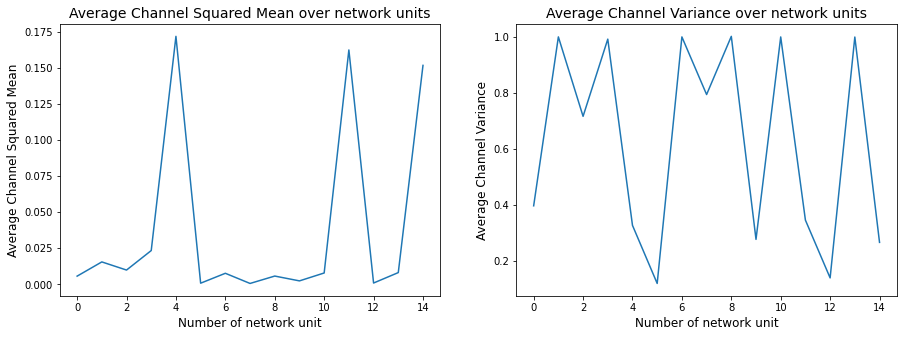

In [8]:
signal_prop = SPP()
signal_prop.SPP_info(model, image_shape=(1, 32, 32), batch_size=3)
print(len(signal_prop.statistics['Average Channel Squared Mean'])) # must be 15
print(signal_prop.modules_instances)

signal_prop.show_SPP_graphs()

# SPP for ResNet from batchflow

In [9]:
import sys
sys.path.append("..")

In [10]:
from batchflow.models.torch import ResNet

In [11]:
num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu'
}

model = ResNet(model_config).model

42
['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'AdaptiveAvgPool2d', 'Dropout', 'Linear']


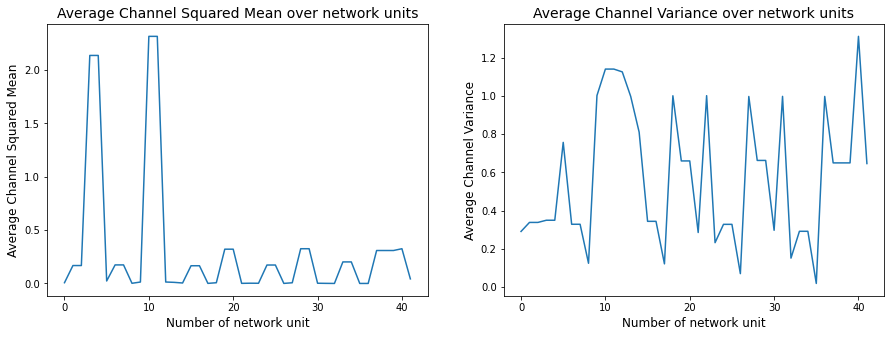

In [12]:
signal_prop = SPP()
signal_prop.SPP_info(model, image_shape=(1, 32, 32), batch_size=3)
print(len(signal_prop.statistics['Average Channel Squared Mean'])) # must be 42
print(signal_prop.modules_instances)

signal_prop.show_SPP_graphs()

# Third Model

## pre-activated

In [13]:
from batchflow.models.torch import ResNet34

num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu',
    'body/encoder/blocks/layout': 'nacnac',
    'body/encoder/blocks/op': '+'
}

model = ResNet34(model_config).model

138
['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Conv2d', 'BatchNorm2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Conv2d', 'BatchNorm2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU'

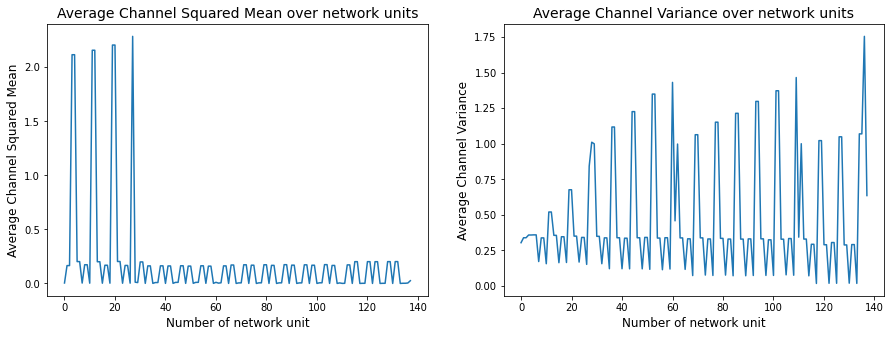

In [14]:
signal_prop = SPP()
signal_prop.SPP_info(model, image_shape=(1, 32, 32), batch_size=3)
print(len(signal_prop.statistics['Average Channel Squared Mean']))
print(signal_prop.modules_instances)

signal_prop.show_SPP_graphs()

## post-activated

In [15]:
from batchflow.models.torch import ResNet34

num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu'
}

model = ResNet34(model_config).model

138
['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2

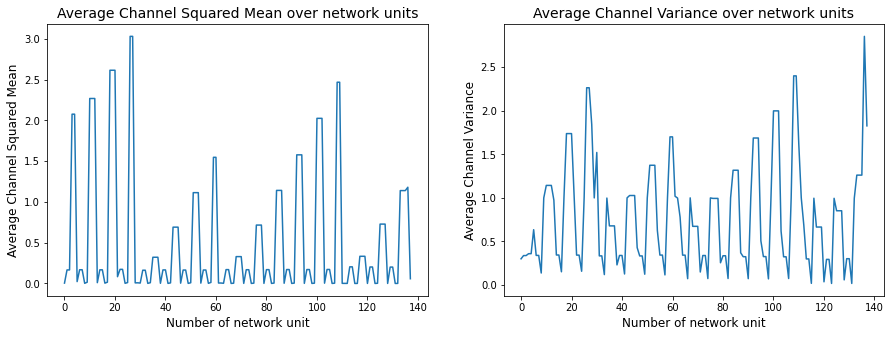

In [16]:
signal_prop = SPP()
signal_prop.SPP_info(model, image_shape=(1, 32, 32), batch_size=3)
print(len(signal_prop.statistics['Average Channel Squared Mean']))
print(signal_prop.modules_instances)

signal_prop.show_SPP_graphs()